In [1]:
import matplotlib.pyplot as plt
import os
from project_classes import *
from functions import *
from iceflow_library import *
from scipy.optimize import curve_fit
import scipy.optimize as opt
import sys

In [2]:
zoom = True
seg_length = 100
# season = "2009_Antarctica_DC8"
season = "2018_Antarctica_DC8"
# season = "2016_Antarctica_DC8" 
# season = "2014_Antarctica_DC8" 
season = "2022_Antarctica_BaslerMKB"

# flight = "20181030_01"  # the flight date and frame number 
# that flight only has one point
flight = "20181018_01"
# flight = "20181103_01"
# flight = "20181011_01"
# one dimensional data error
# TODO: figure out why 10018 and 1103 have the same data or at least print the same maps and plots
# flight = "20181109_01"
# flight = "20181112_02"  # the problem flight
# plots fake crossovers along the curved path
# flight = "20161024_05"
# flight = "20161111_05"
# probably too close to the coast to be useful
# flight = "20161024_05"
# flight = "20141026_06"
flight = "20230127_01"
# ~ 1/3 of an orbit of the pole and yet the angle plot looks like hot garbage
# file_name = "layer_export_" + flight + ".pickle"
file_name = "C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\layer_export_" + flight + ".pickle"
testing = False

In [3]:
print(f"Force remaking {file_name}...")
mat_pickler_h5py(season, flight, testing_mode=testing)  # make it
layers = read_layers(file_name)  # read in the layers from the pickle file
print(f"File {file_name} created.")

if not os.path.isfile(
        "C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle"):  # if the file does not exist
    print("The iceflow data pickle file was not found. Creating a new one...")
    filename = iceflow_saver()
    iceflow_data = iceflow_loader(filename)
    print("The iceflow data pickle file was successfully created.")
# try:
iceflow_data = iceflow_loader("C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\iceflow_data.pickle")
print("The iceflow data pickle file was found and loaded.")

x = iceflow_data[0]
y = iceflow_data[1]
velocity_x = iceflow_data[2]
velocity_y = iceflow_data[3]
latitude = iceflow_data[4]
longitude = iceflow_data[5]
print("iceflow data loaded")

filename = f"C:\\Users\\rj\\Documents\\cresis_project\\pickle_jar\\{season}_{flight}_crossover_points.pickle"

print(f"Force remaking {file_name}...")


Force remaking C:\Users\rj\Documents\cresis_project\pickle_jar\layer_export_20230127_01.pickle...
Reading data files...
--------------------
f['param']: <HDF5 group "/param" (6 members)>
f['param'].keys(): ['day_seg', 'radar', 'radar_name', 'records', 'season_name', 'sw_version']


layerize_h5py debug:
f['lat'][:]: [[-88.89395645]
 [-88.89382215]
 [-88.89368786]
 ...
 [-88.44666919]
 [-88.44653489]
 [-88.4464006 ]]
f['lat'][:]: -88.8939564477804



layer1: Surface number of points: 96358
layer2: Bottom number of points: 96358
--------------------
C:\Users\rj\Documents\cresis_project\pickle_jar\layer_export_20230127_01.pickle  saved in local directory of this python file.
--------------------

Reading pickle file...
--------------------
Surface
Bottom
--------------------

File C:\Users\rj\Documents\cresis_project\pickle_jar\layer_export_20230127_01.pickle created.
The iceflow data pickle file was found and loaded.
iceflow data loaded
Force remaking C:\Users\rj\Documents\cresis_project\

In [12]:
def find_segment_intersection(segment1, segment2)->list:
    """
    :param segment1: a list of two points, e.g. [(lat1, lon1), (lat2, lon2)]
    :param segment2: a list of two points, e.g. [(lat1, lon1), (lat2, lon2)]
    :return: the point where the segments intersect, or None if they do not intersect
    """
    line1 = LineString(segment1)  # define a line made from two lat-lon points
    line2 = LineString(segment2)  # define a line made from two lat-lon points
    intersection = line1.intersection(line2)  # find the intersection of the two lines
    # if the intersection is the end point of one of the segments, then it is not a crossover point
    if intersection.geom_type == 'Point':
        if intersection.xy[0][0] == segment1[0][0] or intersection.xy[1][0] == segment1[0][1]:
            print("Intersection is the end point of segment 1 and is not a crossover point.")
            return None
        elif intersection.xy[0][0] == segment1[1][0] or intersection.xy[1][0] == segment1[1][1]:
            return None
        elif intersection.xy[0][0] == segment2[0][0] or intersection.xy[1][0] == segment2[0][1]:
            return None
        elif intersection.xy[0][0] == segment2[1][0] or intersection.xy[1][0] == segment2[1][1]:
            return None
        else:  # intersection is not an end point of either segment, it is a crossover point
            return [intersection.xy[0][0], intersection.xy[1][0]]
            # the format of .xy ends up being [["d"], lat], [["d"], lon] for some damn reason. No clue what "d" is. Handling the brackets here to increase readability downstream.
    return None

def cross_point(layer, seg_length, quiet=False):
    """
    :param seg_length:
    :param layer: a Layer object
    :param quiet: a boolean to suppress print statements
    :return: the point where the lat-lon crosses over its own path.
    purpose: layers[0].lat and layers[0].lon are numpy arrays of the latitudes and longitudes for a flight path. It
    does not connect back to the beginning. This function finds the point where the path crosses over itself. The lat-
    lon of the crossover point will not be exactly the same as the lat-lons in the arrays, but it will be very close.
    """
    verbose = not quiet
    print(section_break)
    # create a list of line segments of length seg_length
    path_segments = []
    segment_ends = []
    # if verbose:
    print(f"Dividing the path into {len(layer.lat) // seg_length} segments of length {seg_length}.")
    for i in range(0, len(layer.lat), seg_length):
        if i + seg_length < len(layer.lat):
            path_segments.append([(layer.lat[i], layer.lon[i]), (layer.lat[i + seg_length], layer.lon[i + seg_length])])
        else:
            path_segments.append([(layer.lat[i], layer.lon[i]), (layer.lat[-1], layer.lon[-1])])

    if verbose:
        print(f"Number of segments: {len(path_segments)}")
    print("Checking for intersections...")
    # check for intersections between the line segments
    rough_intersections = []
    intersecting_segments = []
    for i in range(len(path_segments)):  # for segment #i in the number of segments
        progress_bar(i, len(path_segments))  # display a progress bar of segments checked
        for j in range(i + 1, len(path_segments)):  # for every other segment after segment #i
            if segments_intersect(path_segments[i], path_segments[j]):  # if the segments intersect
                intersection_point = find_segment_intersection(path_segments[i], path_segments[j])  # returns the intersection point [lat, lon] or None
                if intersection_point:  # if there is an intersection
                    rough_intersections.append(intersection_point)
                    intersecting_segments.append([i, j])
                    # if verbose:
                    print(f"Segments {i} and {j} intersect near "
                          f"({intersection_point[0]}, {intersection_point[1]})")

    if verbose:
        print("\nChecking for a more precise intersection...")
    fine_intersections = []
    intersection_indices = []

    printed = False

    print(f"\nNumber of rough intersections: {len(rough_intersections)}\n")
    print("Checking for fine intersections...")

    for seg_pair in range(len(intersecting_segments)):
        progress_bar(seg_pair, len(intersecting_segments))  # display a progress bar

        seg1 = intersecting_segments[seg_pair][0]
        seg2 = intersecting_segments[seg_pair][1]

        # translate segment numbers to indices in the lat-lon arrays
        if seg1 == 0:
            seg1_start = 0
            seg1_end = seg_length
        else:
            seg1_start = seg1 * seg_length
            seg1_end = seg1_start + seg_length
        if seg2 == 0:
            seg2_start = 0
            seg2_end = seg_length
        else:
            seg2_start = seg2 * seg_length
            seg2_end = seg2_start + seg_length
        # if verbose:
        print(f"segment {seg1} start: {seg1_start}, segment 1 end: {seg1_end}")
        # if verbose:
        print(f"segment {seg2} start: {seg2_start}, segment 2 end: {seg2_end}")

        # create a list of line segments of length 1
        path_segments = []
        for i in range(seg1_start, seg1_end):
            path_segments.append([(layer.lat[i], layer.lon[i]), (layer.lat[i + 1], layer.lon[i + 1])])

        for i in range(seg2_start, seg2_end):
            path_segments.append([(layer.lat[i], layer.lon[i]), (layer.lat[i + 1], layer.lon[i + 1])])

        # check for intersections between the line segments
        for first_seg in range(len(path_segments)):  # compare each segment
            for sec_seg in range(first_seg + 1, len(path_segments)):  # to every other segment after it
                if segments_intersect(path_segments[first_seg], path_segments[sec_seg]):  # if they intersect
                    intersection_point = find_segment_intersection(path_segments[first_seg],
                                                                    path_segments[sec_seg])  
                    # find the intersection point, returns [lat, lon] if there is an intersection and None if not 
                    if intersection_point:
                        index1 = seg1_start + first_seg
                        index2 = seg2_start + sec_seg
                        # intersections.append([intersection_points])
                        segment_ends.append([[path_segments[first_seg][0], path_segments[first_seg][1], index1],
                                             [path_segments[sec_seg][0], path_segments[sec_seg][1], index2]])

                        fine_intersections.append([intersection_point[0], intersection_point[1]])
                        # fine_intersections are the first two points of the segment_ends list, i.e. two endpoints on
                        # opposing legs of the X. segment_ends are all four points of the X.
                        if verbose:
                            print(f"Segments {seg1} and {seg2} intersect near indices "
                                  f"{index1} and {index2}\nThis corresponds roughly to the "
                                  f"lat-lon: ({fine_intersections[-1][0]}, {fine_intersections[-1][1]})")
                        intersection_indices.append([index1, index2])


    print(f"\nNumber of intersections: {len(fine_intersections)}\n")
    if verbose:
        print(f"Number of rough intersections: {len(rough_intersections)}")
        print(f"Number of intersection indices: {len(intersection_indices)}")
        # print(f"Indices: {intersect_indices}")
        # for index in intersect_indices:
        #     print(f"Index: {index}: ")
    # for i in range(len(intersection_indices)):
    #     print(f"Index {i}: \n"
    #           f"indices: \t{intersection_indices[i]}\n"
    #           f"lat-lon: \t({fine_intersections[i][0]}, {fine_intersections[i][1]})\n"
    #           f"segment ends: \t{segment_ends[i]}\n"
    #           f"lat-lon by layer: \t({layer.lat[intersection_indices[i][0]]}, {layer.lon[intersection_indices[i][0]]})")

    print(f"Intersection at index {intersection_indices[0][0]} and {intersection_indices[0][1]}")
    for i in range(len(intersection_indices)):
        # TODO Error 1: correct for the fine intersection points being wrong for some reason
        # (lat is close but lon is 6 degrees off in the 20181112_02 flight)
        fine_intersections[i][0] = layer.lat[intersection_indices[i][0]]
        fine_intersections[i][1] = layer.lon[intersection_indices[i][0]]

    print(section_break + "\n")

    return fine_intersections, intersection_indices, segment_ends

In [13]:
intersection_points, intersection_indices, segment_ends = cross_point(layers[0], seg_length, quiet=True)
with open(filename, 'wb') as file:
    pickle.dump(intersection_indices, file)
    pickle.dump(intersection_points, file)
    pickle.dump(segment_ends, file)
print(f"intersection_indices and intersection_points saved to {filename}")

--------------------
Dividing the path into 963 segments of length 100.
Checking for intersections...
[======              ] 30.4%Segments 292 and 635 intersect near (-85.9533136899413, -104.31361078820873)
[======              ] 31.1%Segments 299 and 576 intersect near (-85.87614850349175, -103.61586210626811)
[======              ] 31.8%Segments 306 and 518 intersect near (-85.79820241344451, -102.94363549961245)
[======              ] 32.6%Segments 313 and 463 intersect near (-85.71983010899801, -102.29633217549856)
[======              ] 33.2%Segments 319 and 392 intersect near (-85.64077386016214, -101.67097112427747)
[=================== ] 97.9%Segments 943 and 957 intersect near (-89.93813000047513, -100.4862304759444)
[=================== ] 98.1%Segments 945 and 950 intersect near (-89.96545386820426, -99.9307454900267)
[=================== ] 98.7%Segments 950 and 961 intersect near (-89.96728858874862, -47.17244818566961)
[====================] 100.0%
Number of rough intersect

In [7]:
# print the lat-lon and twtt of the first crossover point

# print(f"layers[1].lat[0]: {layers[1].lat[0]}")
#                             layers[1].lon[i][0])
print(f"segment_ends[0][0][0]: {segment_ends[0][0][2]}")
print(f"segment_ends[0][0]: {segment_ends[0][0]}")


segment_ends[0][0][0]: 29253
segment_ends[0][0]: [(-85.95336842784279, -104.31383823598436), (-85.95325594062754, -104.31279852896284), 29253]


point: nan is not 0. Hopefully it is nan.
point: nan is not 0. Hopefully it is nan.
first cross lat-lon: -85.64084124839901, -101.67166777166437
first segment lat-lon: -85.6407265733461, -101.67074808773873
first cross twtt: 1.0150056015826549e-05
intersection point 4: [-85.64084124839901, -101.67166777166437]


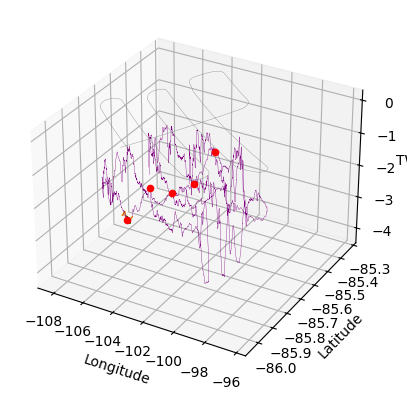

In [5]:
def plot_layers_3d(layers, season, flight, intersect_indices, seg_ends):
    # plot the layers with respect to lat, lon, and twtt
    # plot a grid of scattered points at 0 twtt to represent the surface

    # convert the lat-lon points to xy points
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')


    # plot_all = False
    plot_all = True
    plot_surface = False

    for layer in layers:
        corrected_twtt = layer.twtt - layers[0].twtt  # normalize against the surface layer
        # corrected_twtt = layer.twtt
        layer.twtt_corrected = corrected_twtt

    for point in layers[0].twtt_corrected:
        if point != 0:
            print(f"point: {point} is not 0. Hopefully it is nan.")

    lats_bottom = []
    lons_bottom = []
    twtts_bottom = []
    lats_surf = []
    lons_surf = []
    twtts_surf = []

    for i in range(len(layers[1].lat)):
        lats_bottom.append(layers[1].lat[i])
        lons_bottom.append(layers[1].lon[i])
        twtts_bottom.append(layers[1].twtt_corrected[i])
        # twtts1.append(layers[1].twtt[i])

    for i in range(len(layers[0].lat)):
        lats_surf.append(layers[0].lat[i])
        lons_surf.append(layers[0].lon[i])
        twtts_surf.append(layers[0].twtt_corrected[i])
        # twtts2.append(layers[0].twtt[i])

    # offset = 250
    offset = 150

    i=0
    # for i in range(len(intersect_indices) - 1):

    if plot_surface:
        # plot the surface layer (layer 0)
        ax.plot(lons_surf[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset],
                lats_surf[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset],
                [-x for x in (twtts_surf[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset])], label='top. seg. 1', c='blue',
                linewidth=1)

        ax.plot(lons_surf[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset],
                lats_surf[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset],
                [-x for x in (twtts_surf[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset])], label='top seg. 2', c='black',
                linewidth=1)

        # draw a line from one end of the segment to the other in blue
        # Define the slice range
        start_index = intersect_indices[i][0] - offset
        end_index = intersect_indices[i][0] + offset

        # Extract the sliced arrays
        lons2_slice = lons_surf[start_index:end_index]
        lats2_slice = lats_surf[start_index:end_index]
        twtts2_slice = [-x for x in twtts_surf[start_index:end_index]]

        # plot the distance in meters between the first and last point
        # get the distance in meters between the first and last point
        distance = latlon_dist([lats2_slice[0], lons2_slice[0]], [lats2_slice[-1], lons2_slice[-1]])
        # plot the distance in meters to the first decimal between the first and last point
        ax.text((lons2_slice[0]), (lats2_slice[0]),
                (max(twtts2_slice[0], twtts2_slice[-1])), f"{distance:.1f}m", color='blue')



    start_index_seg1 = intersect_indices[i][1] - offset
    end_index_seg2 = intersect_indices[i][1] + offset

    start_index_seg2 = intersect_indices[i][0] - offset
    end_index_seg1 = intersect_indices[i][0] + offset

    # plot the bottom layer (layer 1)
    # ax.plot(lons_bottom[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset],
    #         lats_bottom[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset],
    #         [-x for x in (twtts_bottom[intersect_indices[i][0] - offset:intersect_indices[i][0] + offset])],
    #         label='bott. seg. 1', c='orange',
    #         linewidth=1)
    #
    # ax.plot(lons_bottom[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset],
    #         lats_bottom[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset],
    #         [-x for x in (twtts_bottom[intersect_indices[i][1] - offset:intersect_indices[i][1] + offset])],
    #         label='bott. seg. 2', c='green',
    #         linewidth=1)

    ax.plot(lons_bottom[start_index_seg1:end_index_seg2],
            lats_bottom[start_index_seg1:end_index_seg2],
            [-x for x in twtts_bottom[start_index_seg1:end_index_seg2]],
            label='bott. seg. 2', c='green', linewidth=1)

    ax.plot(lons_bottom[start_index_seg2:end_index_seg1],
            lats_bottom[start_index_seg2:end_index_seg1],
            [-x for x in twtts_bottom[start_index_seg2:end_index_seg1]],
            label='bott. seg. 1', c='orange', linewidth=1)


    if plot_all:
        # plot the rest of the bottom layer
        ax.plot(lons_bottom[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
                lats_bottom[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
                [-x for x in (twtts_bottom[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset])], label='whole bottom', c='purple',
                linewidth=0.25)

        # plot the rest of the surface layer
        ax.plot(lons_surf[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
                lats_surf[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset],
                [-x for x in (twtts_surf[intersect_indices[0][0] - offset:intersect_indices[0][1] + offset])], label='whole surface', c='grey',
                linewidth=0.25)

    # plot the intersection points
    i = 0

    # for i in range(len(intersection_points) - 1):
    # ax.scatter(intersection_points[i][1], intersection_points[i][0], -1 * twtts_bottom[intersect_indices[i][0]],
    #            c='red', marker='o')
    # ax.scatter(intersection_points[i][1], intersection_points[i][0], -1 * twtts_bottom[intersect_indices[i][1]],
    #            c='black', marker='o')
    #
    # ax.scatter(layers[1].lon[intersect_indices[i][0]],
    #            layers[1].lat[intersect_indices[i][0]],
    #            -1 * layers[1].twtt_corrected[intersect_indices[i][0]], c='green', marker='o')
    # ax.scatter(layers[1].lon[intersect_indices[i][1]],
    #            layers[1].lat[intersect_indices[i][1]],
    #            -1 * layers[1].twtt_corrected[intersect_indices[i][1]], c='blue', marker='o')

    # plot the segment_ends
    for i in range(len(seg_ends)-1):
        # ax.scatter(seg_ends[i][0][0][0], seg_ends[i][0][0][1], -1 * corrected_twtt[seg_ends[i][0][2]], c='red', marker='o')
        ax.scatter(seg_ends[i][0][0][1], seg_ends[i][0][0][0], -1 * corrected_twtt[seg_ends[i][0][2]], c='red', marker='o')

    # i = 0
    # ax.scatter(seg_ends[i][0][0][0], seg_ends[i][0][0][1], -1 * corrected_twtt[seg_ends[i][0][2]], c='red', marker='o')
    
    print(f"first cross lat-lon: {seg_ends[i][0][0][0]}, {seg_ends[i][0][0][1]}")
    print(f"first segment lat-lon: {seg_ends[i][0][1][0]}, {seg_ends[i][0][1][1]}")
    print(f"first cross twtt: {corrected_twtt[seg_ends[i][0][2]]}")


    # print(f"by way of twtt_bottom: \t{twtts_bottom[intersect_indices[i][0]]}")  # red one
    # print(f"by way of twtt_bottom: \t{twtts_bottom[intersect_indices[i][1]]}")  # black one
    # print(f"by way of twtt_corrected: \t{layers[1].twtt_corrected[intersect_indices[i][0]]}")  # green one
    # print(f"by way of twtt_corrected: \t{layers[1].twtt_corrected[intersect_indices[i][1]]}")  # blue one



    #     # label the points with their index
    print(f"intersection point {i}: {intersection_points[i]}")


    # add a legend without the whole bottom and whole surface
    # ax.legend(labels=[f'{l.get_label()}' for l in ax.lines[::2]], bbox_to_anchor=(1.1, 1.05))
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_zlabel('TWTT')
    plt.show()

plot_layers_3d(layers, season, flight, intersection_indices, segment_ends)

In [6]:
print(segment_ends[0][0][0])
print(segment_ends[0][0][1])
print(segment_ends[0][0])
print("")
print(segment_ends[0][1][0])
print(segment_ends[0][1][1])
print(segment_ends[0][1])
print("")
print(segment_ends[0])


(-85.95336842784279, -104.31383823598436)
(-85.95325594062754, -104.31279852896284)
[(-85.95336842784279, -104.31383823598436), (-85.95325594062754, -104.31279852896284), 29253]

(-85.95332237124342, -104.31346984061088)
(-85.95339582068333, -104.31187657863418)
[(-85.95332237124342, -104.31346984061088), (-85.95339582068333, -104.31187657863418), 63621]

[[(-85.95336842784279, -104.31383823598436), (-85.95325594062754, -104.31279852896284), 29253], [(-85.95332237124342, -104.31346984061088), (-85.95339582068333, -104.31187657863418), 63621]]
